In [9]:
import torch 
import torchvision 
import matplotlib.pyplot as plt
import torch.nn as nn 
import torch.nn.functional as F
import numpy as np


transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307, ), (0.3081))
])

#downloading MNIST dataset and checking batch normalization effect in it 
train_set = torchvision.datasets.MNIST(root="../", train=True,transform=transform, download=True)
test_set = torchvision.datasets.MNIST("../", train=False, transform=transform, download=True)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size_train = 32
batch_size_test = 100

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size_train, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size_test, shuffle = True)



In [10]:
device 

device(type='cuda')

In [11]:
#constructing a neural network 
class Network_BN(nn.Module):
    def __init__(self):
        super(Network_BN, self).__init__()
        #default stride = 1, padding = 0, dilation = 1 ??, 28*28
        # 10 1x3x3
        self.conv1 = nn.Conv2d(in_channels = 1,out_channels = 10, kernel_size =3)
        #gives output 10x26x26
        #with maxpool gives 10x13x13
        self.bn1 = nn.BatchNorm2d(10) 
        
        #20 10x3x3
        self.conv2 = nn.Conv2d(in_channels = 10,out_channels = 20, kernel_size=3)
        # gives output 20x11x11 but with maxpool, gives 20x5x5
        
        self.bn2 = nn.BatchNorm2d(20)

        self.drop = nn.Dropout2d()
        #output of conv = out_channels * H2*W2
        
        #20x3x3
        self.linear1 = nn.Linear(500, 50)

        self.bn3 = nn.BatchNorm1d(50)

        self.linear2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.bn1(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.drop(self.bn2(self.conv2(x))), 2))
        x = x.view(-1, 500)
#         print(f'{x.shape} is the shape of x')
        x = F.relu(self.bn3(self.linear1(x)))
        x = F.dropout(x, training=self.training)
        x = self.linear2(x)
        return F.log_softmax(x)   

In [16]:
network = Network_BN() 
network = network.to(device) 
network 

Network_BN(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout2d(p=0.5, inplace=False)
  (linear1): Linear(in_features=500, out_features=50, bias=True)
  (bn3): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=50, out_features=10, bias=True)
)

In [17]:
def train(model, n_epochs=20):
    # number of epochs to train the model
    n_epochs = n_epochs
    # track losses
    losses = []
        
    # optimization strategy 
    # specify loss function (categorical cross-entropy)
    criterion = nn.CrossEntropyLoss()

    # specify optimizer (stochastic gradient descent) and learning rate = 0.01
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

    # set the model to training mode
    model.train()
    
    for epoch in range(1, n_epochs+1):
        # monitor training loss
        train_loss = 0.0

        ###################
        # train the model #
        ###################
        batch_count = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data.to(device))
            # calculate the loss
            loss = criterion(output, target.to(device))
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update average training loss
            train_loss += loss.item() # add up avg batch loss
            batch_count +=1                

        # print training statistics 
        losses.append(train_loss/batch_count)
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch, 
            train_loss/batch_count))
    
    # return all recorded batch losses
    return losses

In [18]:
len(test_loader), len(train_loader)

(100, 1875)

In [19]:
losses_with_norm = train(network)

C:\Users\OMEN\AppData\Local\Temp\ipykernel_2816\1929942398.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Epoch: 1 	Training Loss: 0.811141
Epoch: 2 	Training Loss: 0.394958
Epoch: 3 	Training Loss: 0.322994
Epoch: 4 	Training Loss: 0.285838
Epoch: 5 	Training Loss: 0.259651
Epoch: 6 	Training Loss: 0.247534
Epoch: 7 	Training Loss: 0.236151
Epoch: 8 	Training Loss: 0.221017
Epoch: 9 	Training Loss: 0.216555
Epoch: 10 	Training Loss: 0.208433
Epoch: 11 	Training Loss: 0.205632
Epoch: 12 	Training Loss: 0.199846
Epoch: 13 	Training Loss: 0.197508
Epoch: 14 	Training Loss: 0.196279
Epoch: 15 	Training Loss: 0.189717
Epoch: 16 	Training Loss: 0.190988
Epoch: 17 	Training Loss: 0.185859
Epoch: 18 	Training Loss: 0.184007
Epoch: 19 	Training Loss: 0.180349
Epoch: 20 	Training Loss: 0.179659


In [20]:
torch.save(network.state_dict(), 'trained_model_BN.pth')

In [21]:
NoNormLoss = np.array(losses_with_norm)

In [22]:
def test(model, train):
    # initialize vars to monitor test loss and accuracy
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    test_loss = 0.0
    test_losses = []

    # set model to train or evaluation mode
    # just to see the difference in behavior
    if(train==True):
        model.train()
    if(train==False):
        model.eval()
    
    # loss criterion
    criterion = nn.CrossEntropyLoss()
    
    for batch_idx, (data, target) in enumerate(test_loader):
        batch_size = data.size(0)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data.to(device))
        # calculate the loss
        loss = criterion(output, target.to(device))
        # update average test loss 
        test_loss += loss.item()*batch_size
        
        if batch_idx%10==0:
            test_losses.append(loss.item())
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.to(device).data.view_as(pred)))
        # calculate test accuracy for each object class
        for i in range(batch_size):
            label = target.to(device).data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    print('Test Loss: {:.6f}\n'.format(test_loss/len(test_loader.dataset)))

    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                str(i), 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (class_correct[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))
    
    return test_losses

In [23]:
test_loss_train = test(network, train=True)
test_loss_train =  np.array(test_loss_train)
test_loss_eval = test(network, train=False)
test_loss_eval = np.array(test_loss_eval)
test_loss_train, test_loss_eval

C:\Users\OMEN\AppData\Local\Temp\ipykernel_2816\1929942398.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Test Loss: 0.141196

Test Accuracy of     0: 97% (954/980)
Test Accuracy of     1: 98% (1119/1135)
Test Accuracy of     2: 95% (986/1032)
Test Accuracy of     3: 96% (974/1010)
Test Accuracy of     4: 95% (939/982)
Test Accuracy of     5: 94% (846/892)
Test Accuracy of     6: 96% (925/958)
Test Accuracy of     7: 94% (975/1028)
Test Accuracy of     8: 94% (916/974)
Test Accuracy of     9: 94% (950/1009)

Test Accuracy (Overall): 95% (9584/10000)
Test Loss: 0.043778

Test Accuracy of     0: 99% (974/980)
Test Accuracy of     1: 99% (1132/1135)
Test Accuracy of     2: 99% (1022/1032)
Test Accuracy of     3: 98% (997/1010)
Test Accuracy of     4: 98% (966/982)
Test Accuracy of     5: 98% (880/892)
Test Accuracy of     6: 98% (946/958)
Test Accuracy of     7: 98% (1010/1028)
Test Accuracy of     8: 98% (955/974)
Test Accuracy of     9: 97% (983/1009)

Test Accuracy (Overall): 98% (9865/10000)


(array([0.14899869, 0.05870708, 0.10998398, 0.1359953 , 0.10043215,
        0.10631517, 0.09510013, 0.30365428, 0.10518607, 0.16192894]),
 array([0.02774242, 0.03705984, 0.01126399, 0.03141224, 0.04684197,
        0.06480875, 0.00545127, 0.01945538, 0.12225097, 0.04986453]))

In [24]:
np.save('train_loss_bn.npy', NoNormLoss)
np.save('test_loss_train_bn.npy', test_loss_train)
np.save('test_loss_eval_bn.npy', test_loss_eval)

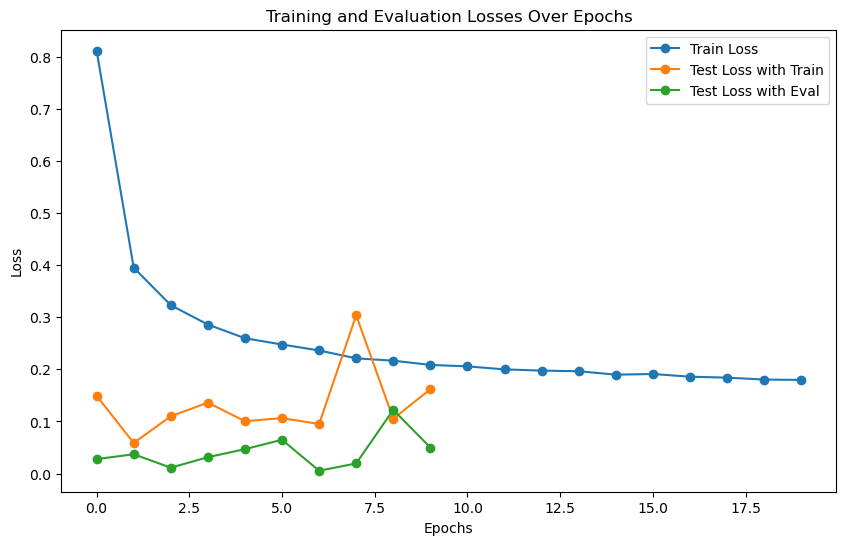

In [25]:
# Plotting the losses
plt.figure(figsize=(10, 6))
plt.plot( NoNormLoss, label='Train Loss', marker='o')
plt.plot(test_loss_train, label='Test Loss with Train', marker='o')
plt.plot( test_loss_eval, label='Test Loss with Eval', marker='o')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Evaluation Losses Over Epochs')
plt.legend()

# Show the plot
plt.show()